<img src="https://media.istockphoto.com/id/1272421423/vector/tiny-doctor-insert-sample-with-blood-into-digital-glucose-meter-to-control-diabetes-sickness.jpg?s=170667a&w=0&k=20&c=6GyC6wwx8CFoU0K4-9XMARhszSfs1LutZfREoW7ZOiE=" width=1600 height=800 />

# Data Alchemy: Transforming Diabetes Data with Feature Engineering Wizardry

<div style="text-align: justify">Welcome to this Jupyter notebook project, where we delve into the realm of feature engineering to develop a machine learning model for predicting whether individuals have diabetes. Our primary goal is to emphasize the significance of data analysis and feature engineering in building reliable predictive models. Before we proceed to model development, we will conduct essential data analysis steps and explore feature engineering techniques to extract meaningful information from the dataset. By focusing on these foundational aspects, we aim to lay a solid foundation for a robust and interpretable model, highlighting the essential role of feature engineering in diabetes prediction. Let's embark on this enriching journey of transforming raw data into valuable insights for accurate predictions. </div>

## Dataset Information

<div style="text-align: justify">The dataset is a part of a large dataset maintained by the National Institute of Diabetes and Digestive and Kidney Diseases in the United States. It is specifically related to a diabetes research study conducted on Pima Indian women, aged 21 and above, residing in Phoenix, the largest city in the state of Arizona. The dataset contains valuable information used for investigating diabetes prevalence among the study participants.</div>

<div style="text-align: justify">The target variable, labeled as "outcome," is the focal point of the analysis. It is binary, with a value of 1 indicating a positive diabetes test result and 0 indicating a negative result. The dataset's attributes encompass diverse features, such as pregnancies, glucose levels, blood pressure, skin thickness, insulin levels, diabetes pedigree function, body mass index (BMI), and age, which are expected to contribute to the prediction of diabetes presence in the participants. The dataset offers an opportunity to delve into the world of feature engineering and machine learning to create a reliable model that can predict the likelihood of individuals having diabetes based on the provided features.</div>

- Pregnancies: Number of pregnancies
- Glucose: 2-hour plasma glucose concentration in an oral glucose tolerance test
- Blood Pressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skinfold thickness (mm)
- Insulin: 2-hour serum insulin (mu U/ml)
- DiabetesPedigreeFunction: Diabetes pedigree function, providing a measure of the genetic influence of diabetes
- BMI: Body mass index (weight in kg / (height in m)^2)
- Age: Age in years
- Outcome: Whether the individual has diabetes (1) or does not have diabetes (0)

## Imported Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Defined Functions

In [2]:
def uniqueInfos(df):
    
    dictz = {"FEATURES": df.columns,
             "N_UNIQUE": [df[item].nunique() for item in df.columns],
             "N_NULL": [df[item].isnull().sum() for item in df.columns],
             "ITEMS": [df[item].unique() for item in df.columns],
             "TYPE" : [df[item].dtype for item in df.columns]}
    
    return pd.DataFrame(data = dictz)

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return round(low_limit), round(up_limit)


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [3]:
flist = [file for file in os.listdir(os.getcwd()) if ".csv" in file]
df    = pd.read_csv(flist[0])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [5]:
uniqueInfos(df)

,FEATURES,N_UNIQUE,N_NULL,ITEMS,TYPE
0,Pregnancies,17,0,"[6, 1, 8, 0, 5, 3, 10, 2, 4, 7, 9, 11, 13, 15,...",int64
1,Glucose,136,0,"[148, 85, 183, 89, 137, 116, 78, 115, 197, 125...",int64
2,BloodPressure,47,0,"[72, 66, 64, 40, 74, 50, 0, 70, 96, 92, 80, 60...",int64
3,SkinThickness,51,0,"[35, 29, 0, 23, 32, 45, 19, 47, 38, 30, 41, 33...",int64
4,Insulin,186,0,"[0, 94, 168, 88, 543, 846, 175, 230, 83, 96, 2...",int64
5,BMI,248,0,"[33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31.0, 35....",float64
6,DiabetesPedigreeFunction,517,0,"[0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.2...",float64
7,Age,52,0,"[50, 31, 32, 21, 33, 30, 26, 29, 53, 54, 34, 5...",int64
8,Outcome,2,0,"[1, 0]",int64


In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print("")
print("Categorical Columns: ", ", ".join(str(item) for item in cat_cols))
print("Numerical Columns  : ", ", ".join(str(item) for item in num_cols))

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1

Categorical Columns:  Outcome
Numerical Columns  :  Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age


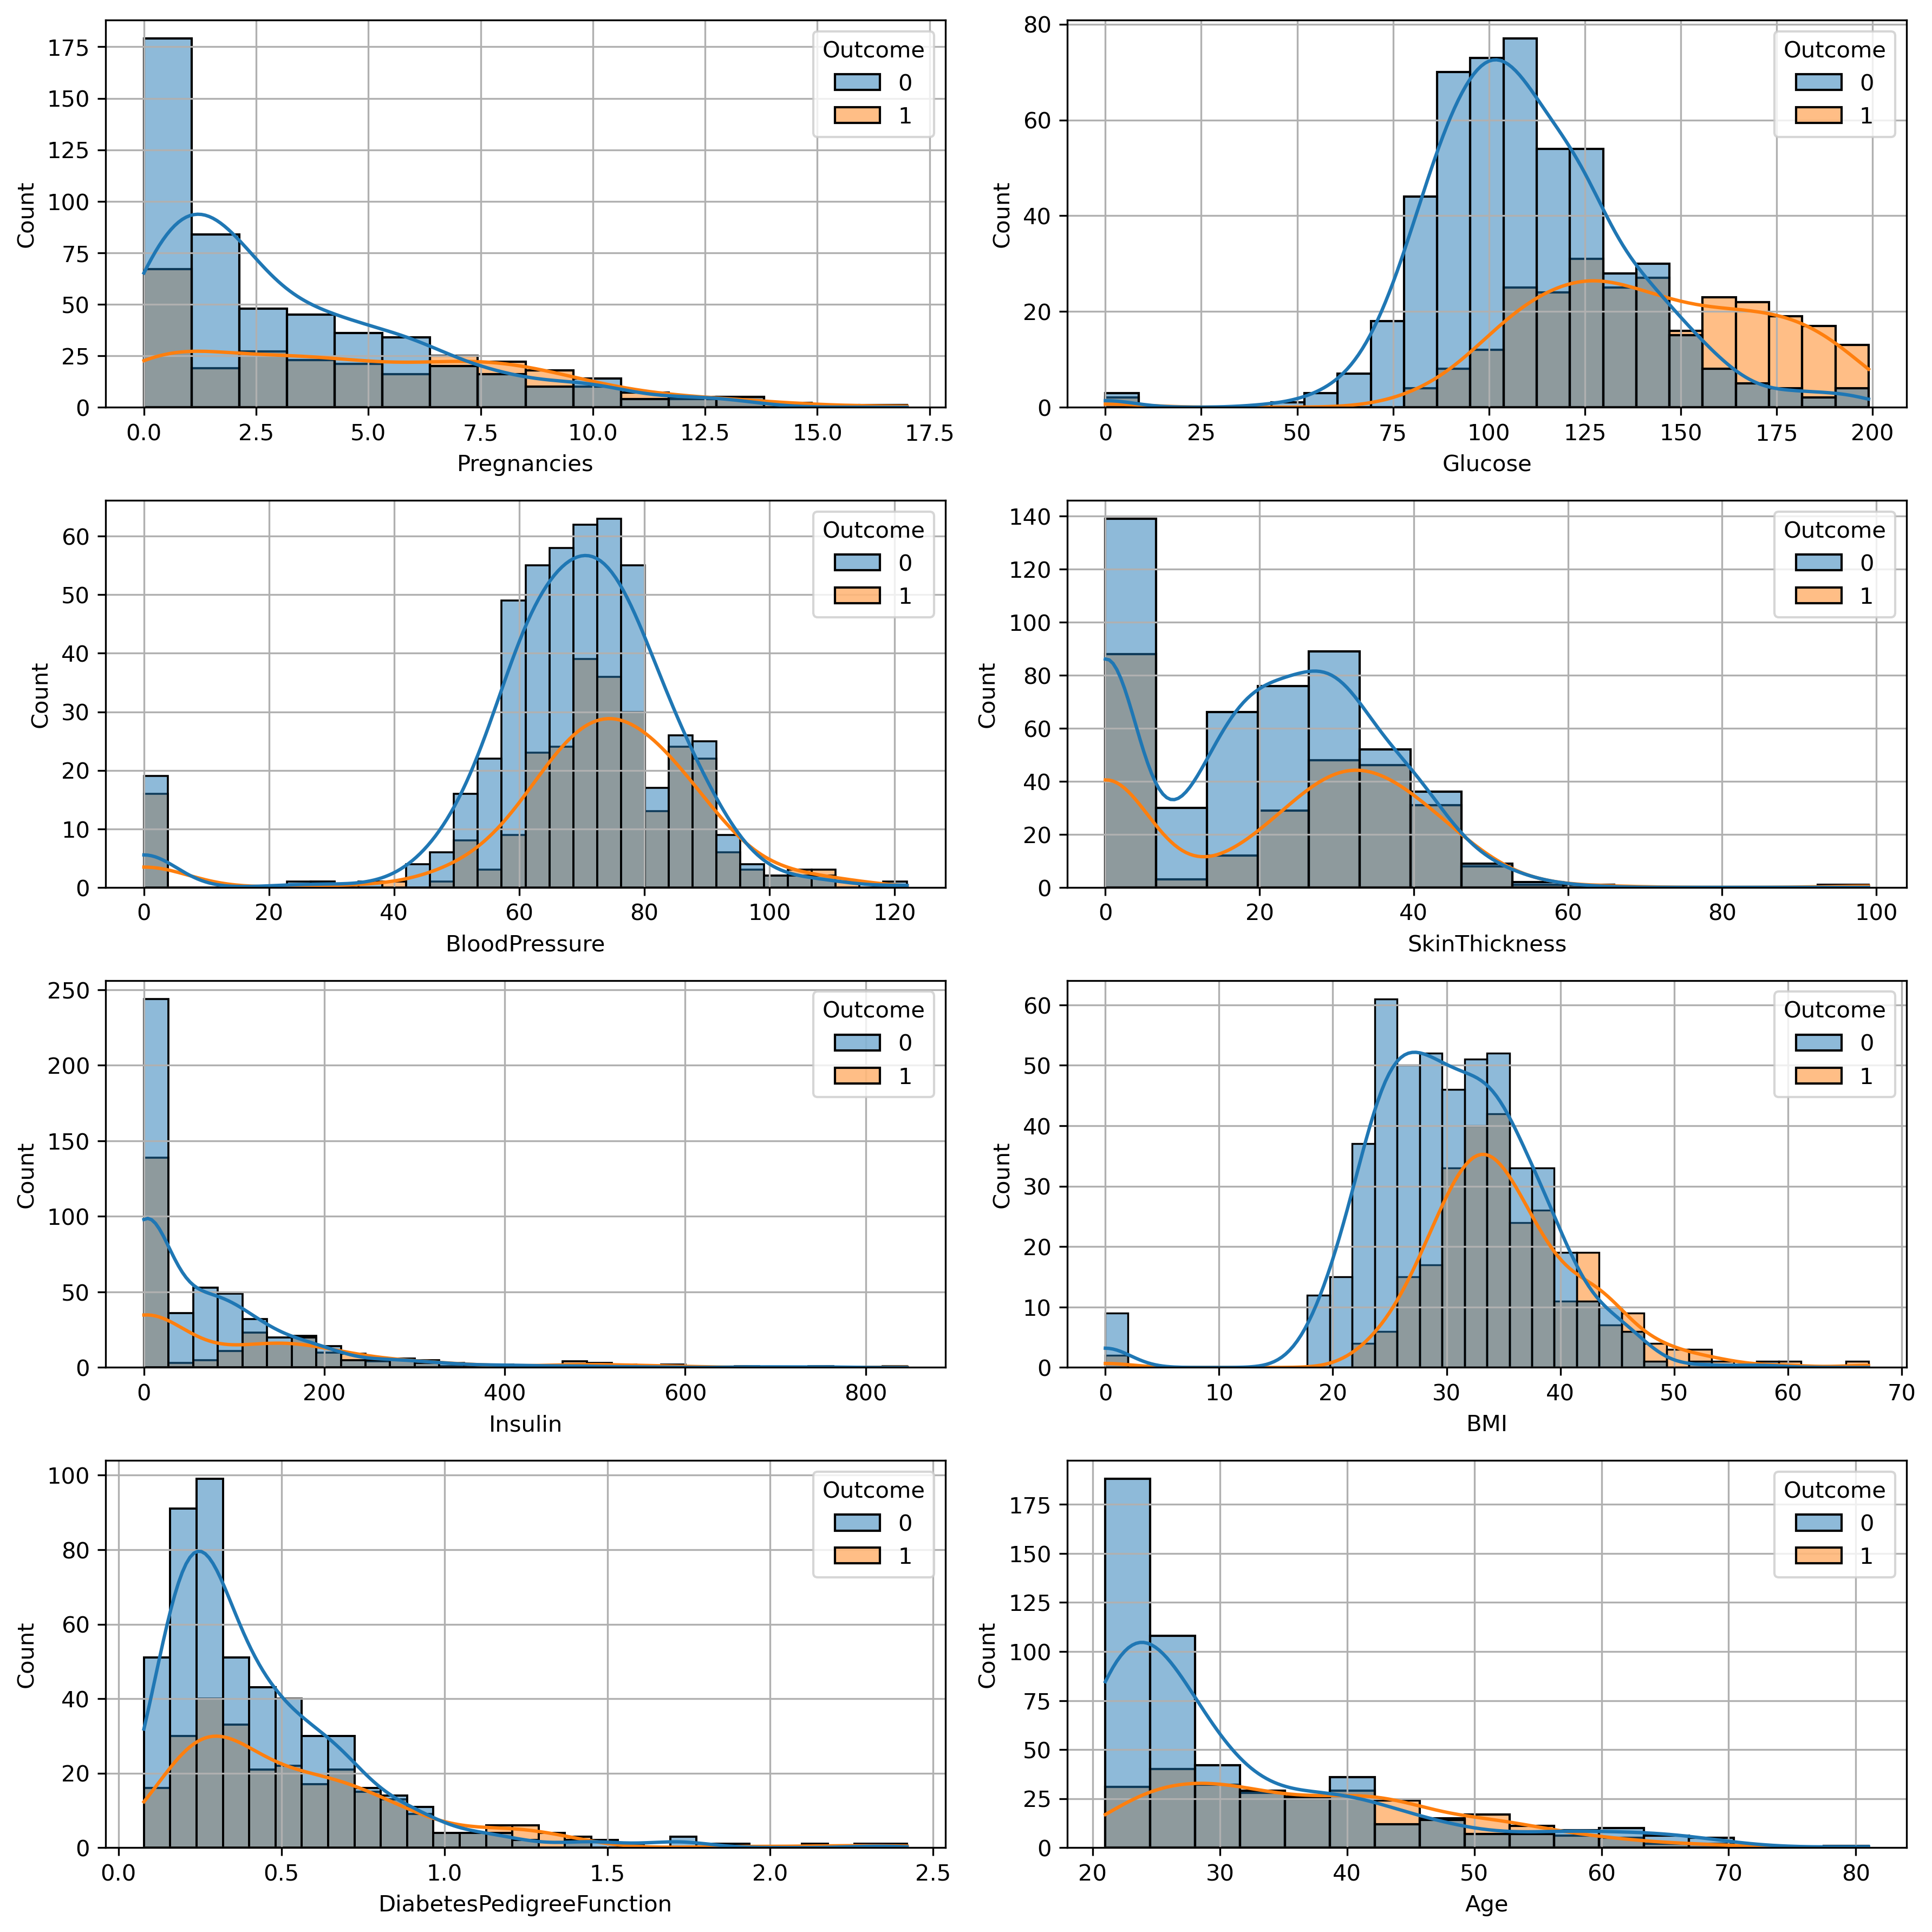

In [7]:
m, n = 4, 2
w = 0

fig, axes = plt.subplots(m, n, figsize = (12, 12), dpi = 300)

for i in range(m):
    for j in range(n):
        sns.histplot(data = df,
                     x = num_cols[w],
                     hue = "Outcome",
                     kde = True,
                     ax = axes[i, j])
        
        axes[i, j].grid(True)
        
        w = w+1
        
plt.tight_layout()

In [8]:
df.groupby(by = "Outcome").agg({col: "min mean max".split() for col in num_cols})

Pregnancies           Glucose              BloodPressure              \
                min  mean max     min    mean  max           min   mean  max   
Outcome                                                                        
0                 0 3.298  13       0 109.980  197             0 68.184  122   
1                 0 4.866  17       0 141.257  199             0 70.825  114   

        SkinThickness            Insulin                BMI                \
                  min   mean max     min    mean  max   min   mean    max   
Outcome                                                                     
0                   0 19.664  60       0  68.792  744 0.000 30.304 57.300   
1                   0 22.164  99       0 100.336  846 0.000 35.143 67.100   

        DiabetesPedigreeFunction             Age             
                             min  mean   max min   mean max  
Outcome                                                      
0                          0.078 0.430 2.329  21 31.190  81  
1                          0.088 0.550 2.420  21 37.067  70

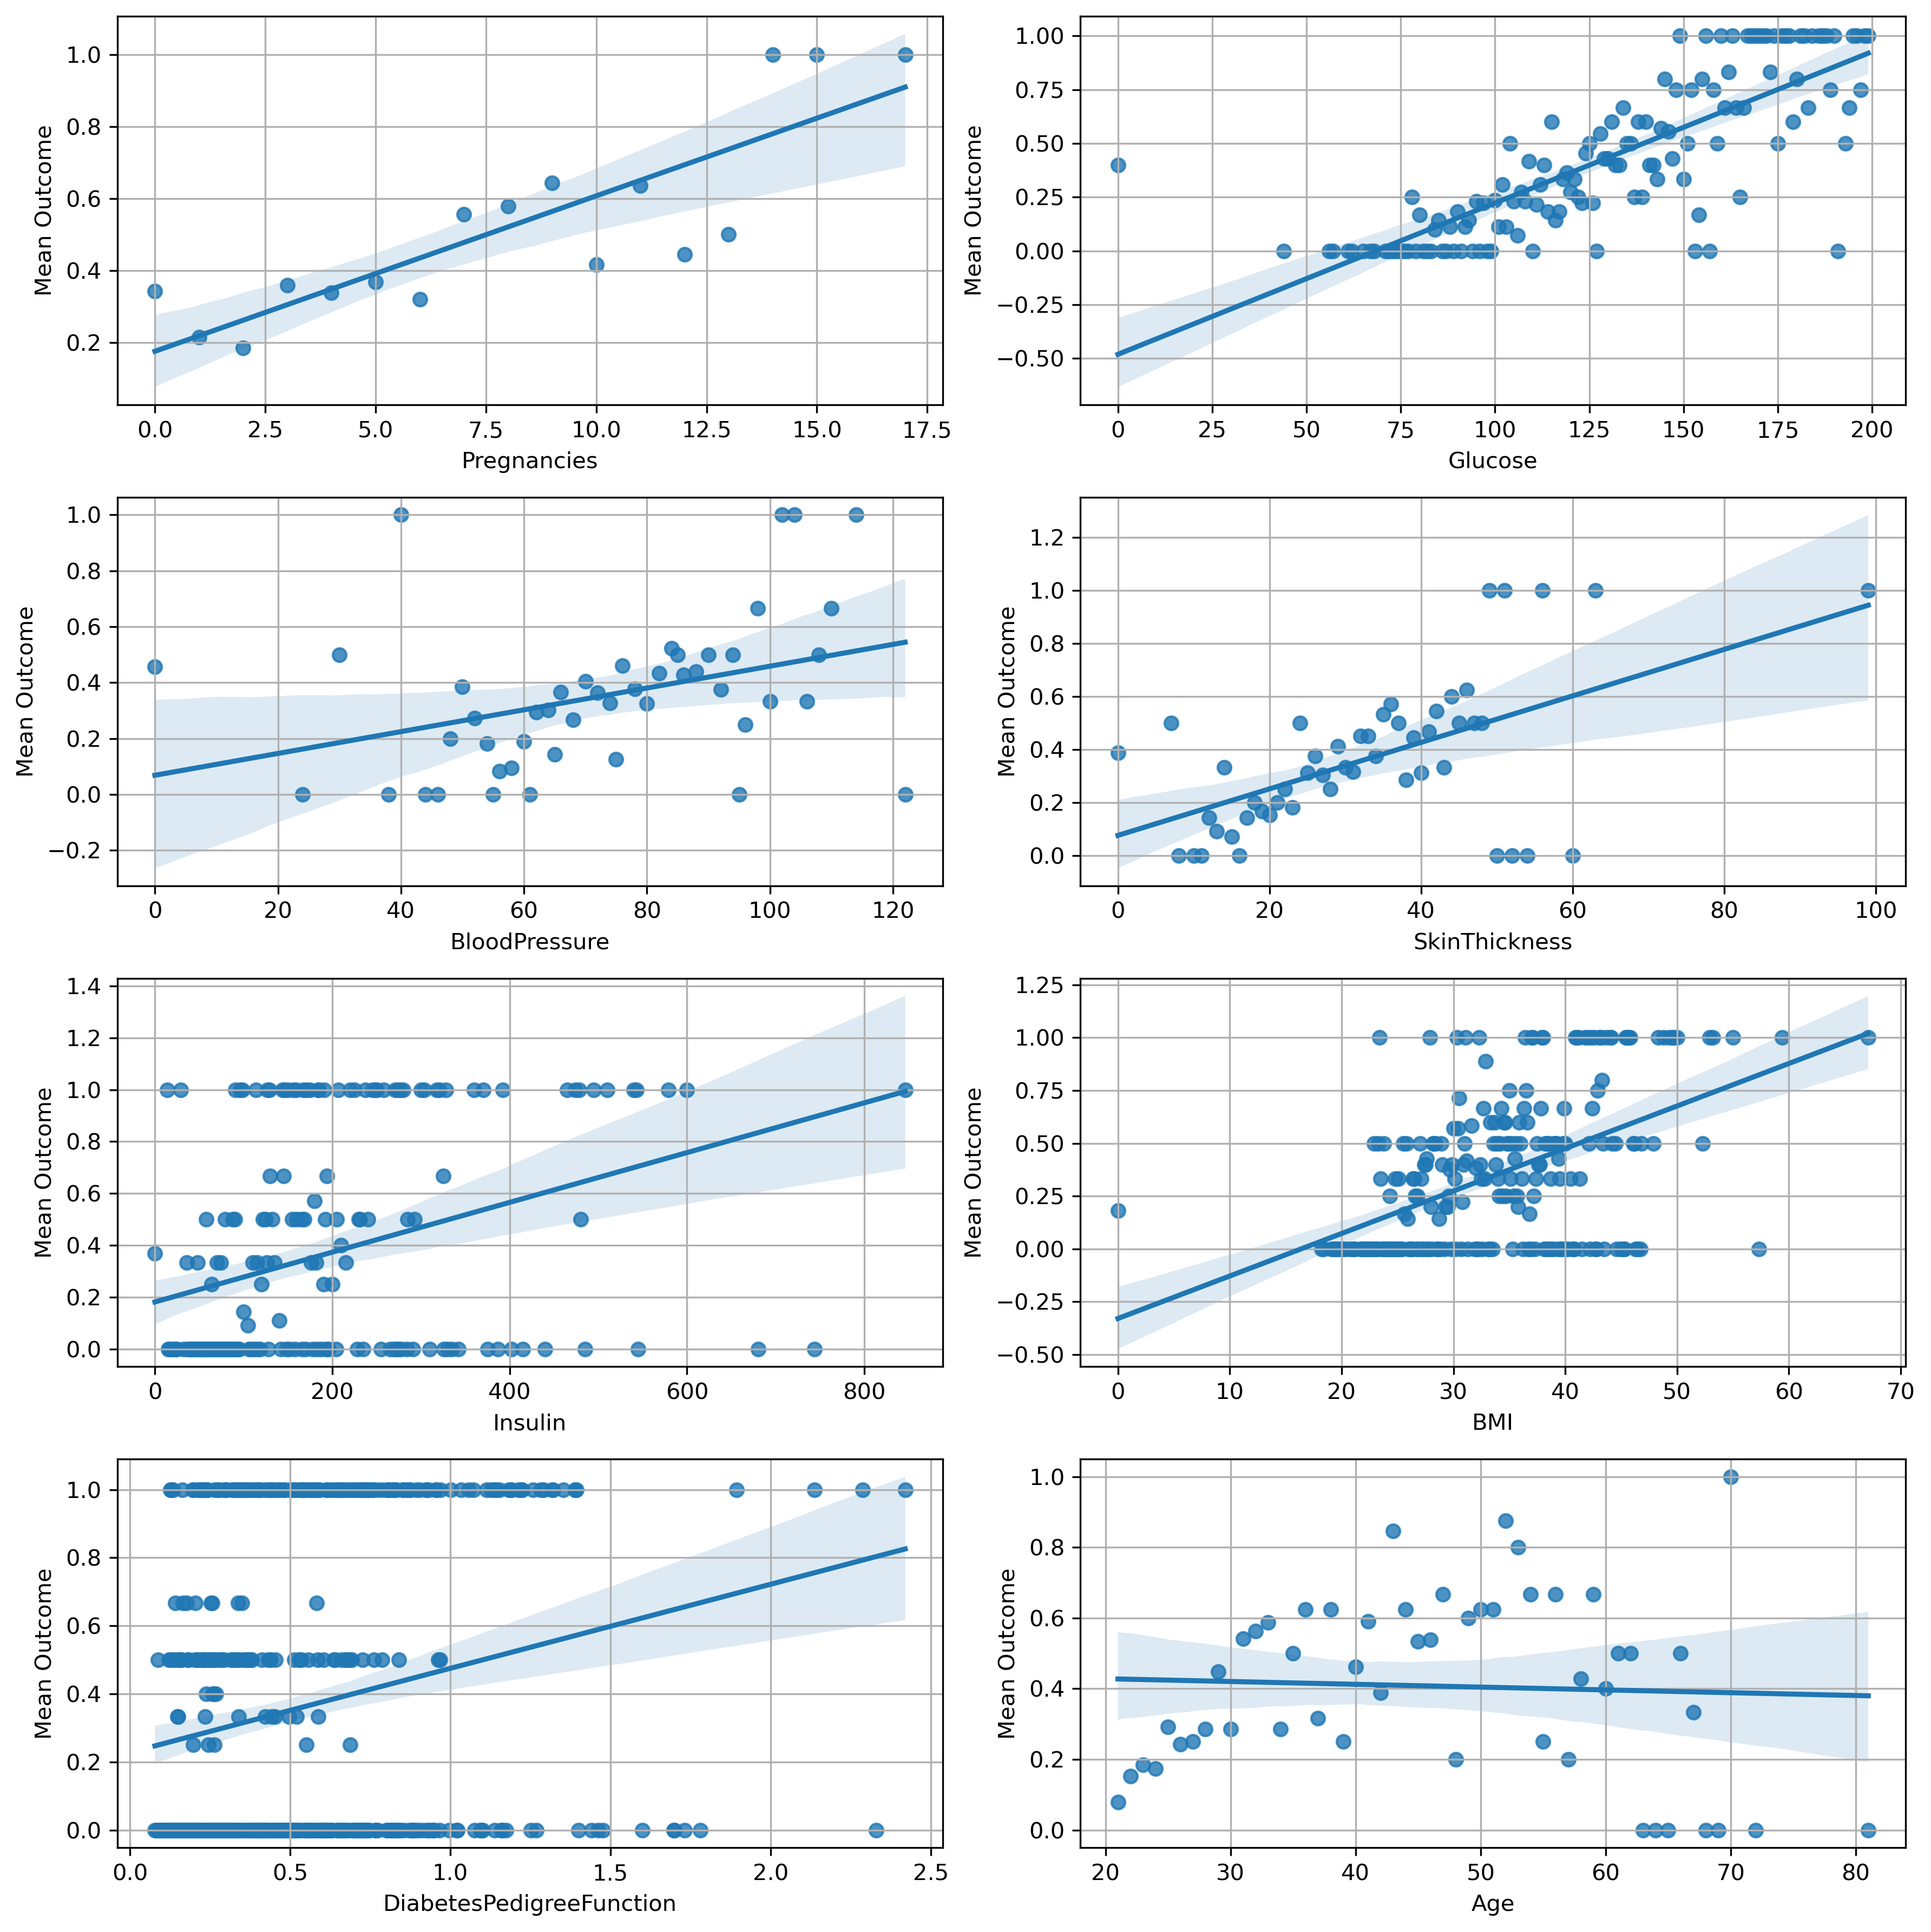

In [9]:
m, n = 4, 2
w = 0

fig, axes = plt.subplots(m, n, figsize = (12, 12), dpi = 300)

for i in range(m):
    for j in range(n):
        
        mean_df = df.groupby(by = num_cols[w]).agg({col: "mean".split() for col in cat_cols}).reset_index()
        mean_df.columns = mean_df.columns.droplevel(1)
        mean_df.columns = [num_cols[w], "Mean Outcome"]
        
        sns.regplot(data = mean_df,
                     x = num_cols[w],
                     y = "Mean Outcome",
                     ax = axes[i, j])
        
        axes[i, j].grid(True)
        
        w = w+1
        
plt.tight_layout()

<Axes: >

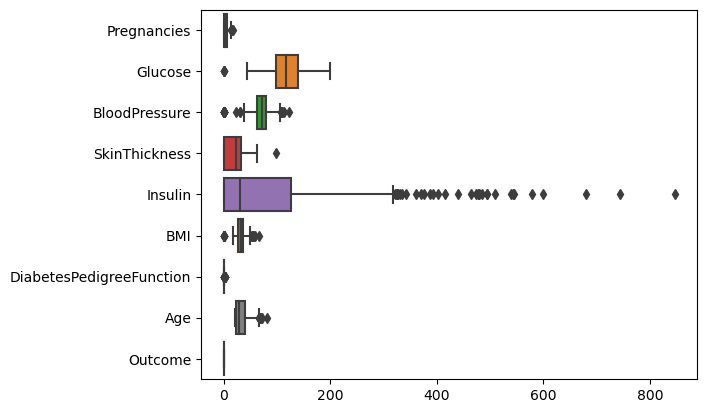

In [10]:
sns.boxplot(data = df, orient = "h")

In [11]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
scores = pd.DataFrame(np.sort(clf.negative_outlier_factor_))
scores.rename(columns={scores.columns[0]: "Outlier Score"}, inplace=True)
#scores.sort_values(by = "Outlier Score", ascending = False)
scores["Score Gradient"] = np.gradient(scores["Outlier Score"], scores.index)
scores.head()

,Outlier Score,Score Gradient
0,-2.597,0.108
1,-2.489,0.078
2,-2.441,0.031
3,-2.427,0.019
4,-2.404,0.025


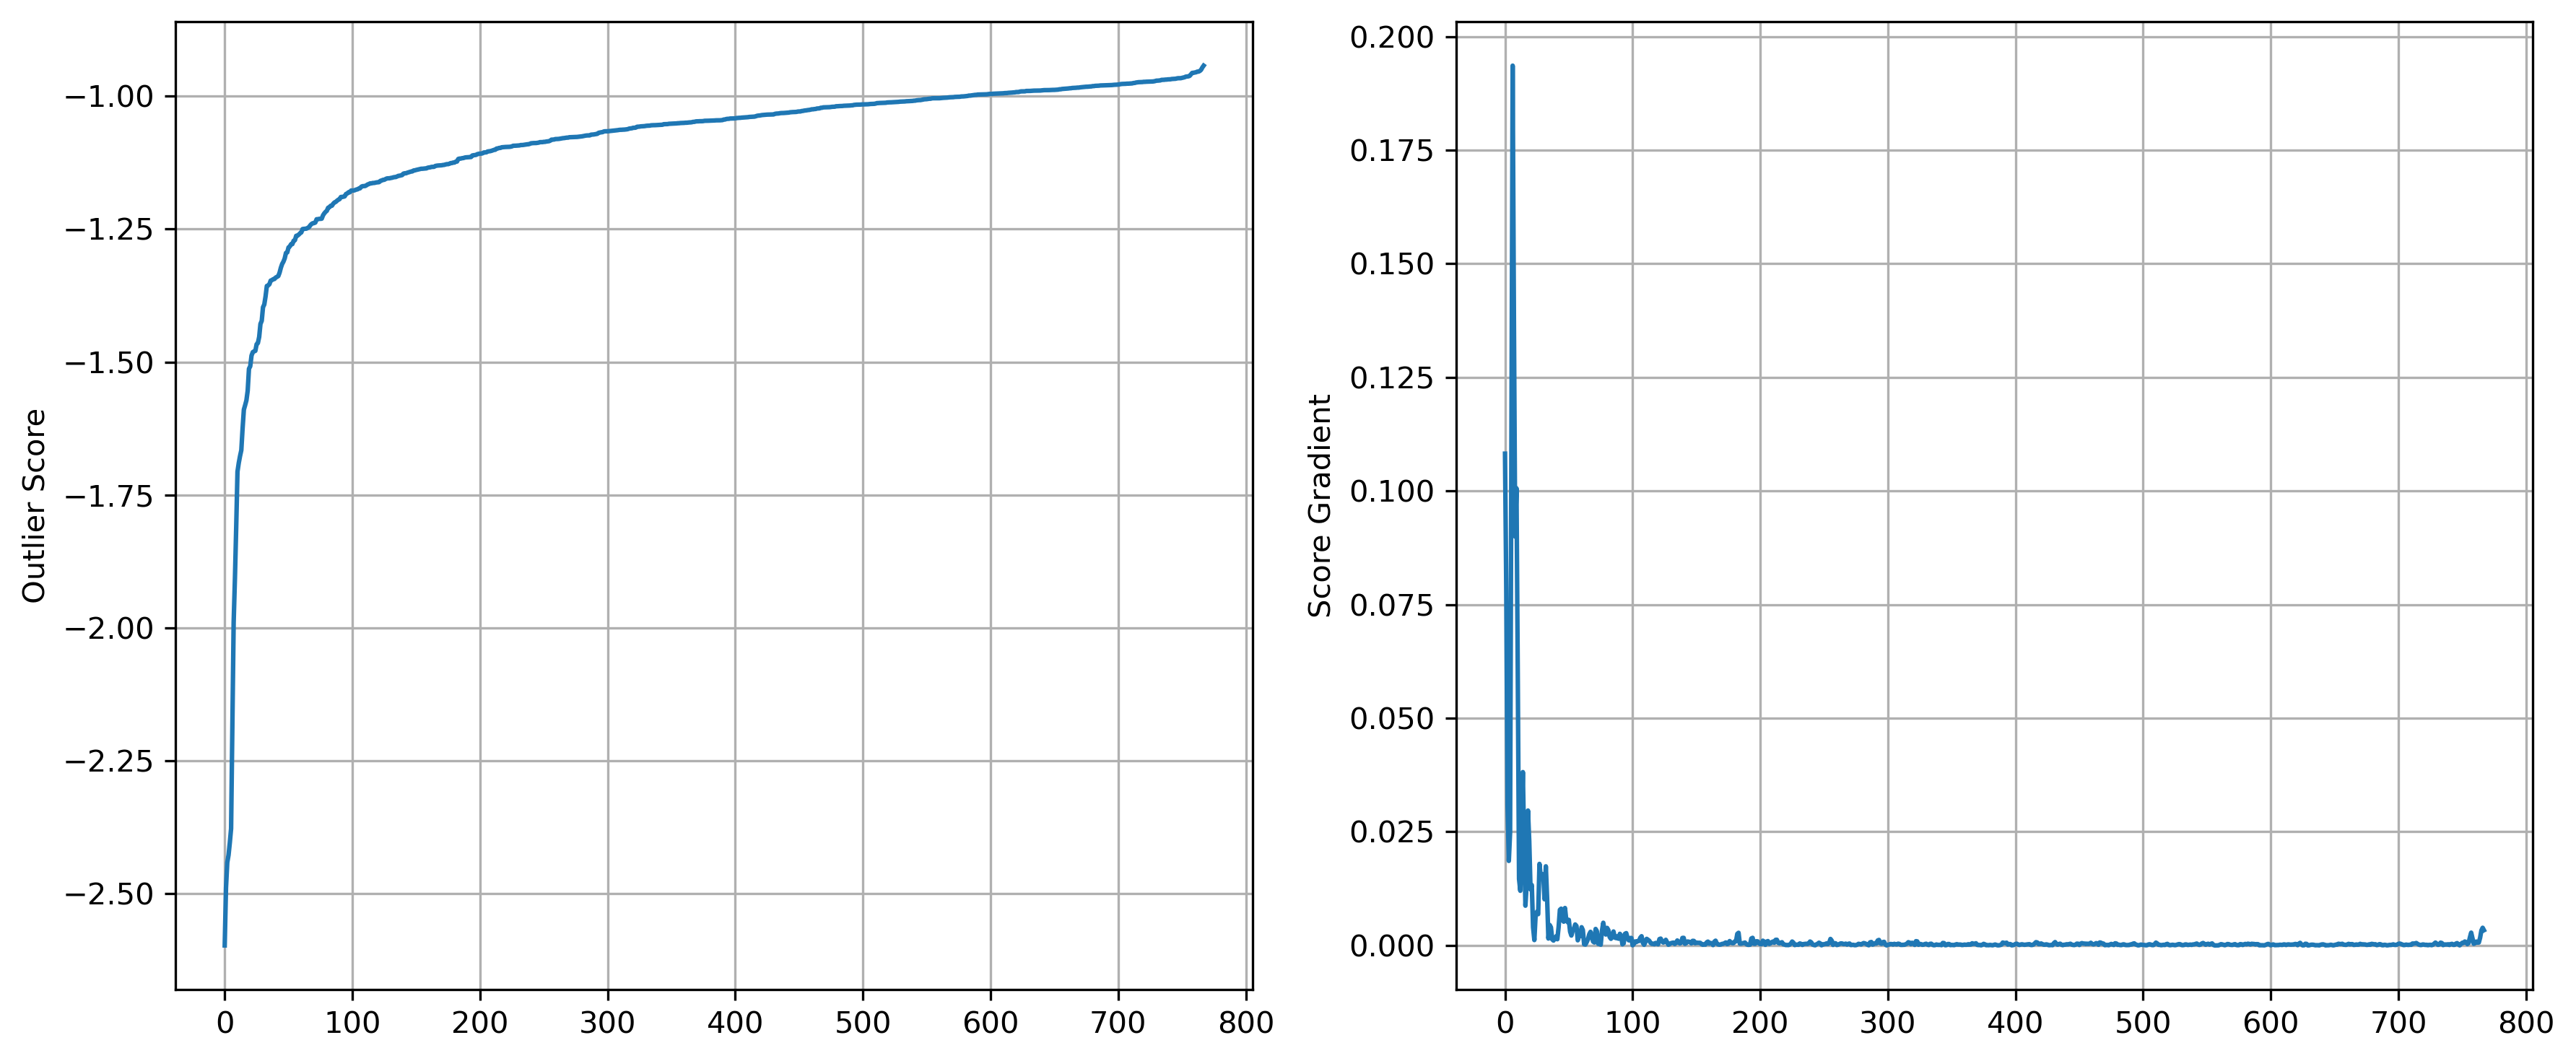

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5), dpi = 300)
sns.lineplot(data = scores, x = scores.index, y = "Outlier Score", ax = axes[0])
sns.lineplot(data = scores, x = scores.index, y = "Score Gradient", ax = axes[1])
axes[0].grid(True)
axes[1].grid(True)
plt.tight_layout()

In [13]:
outlier_df = df[scores["Outlier Score"] < scores.iloc[100]["Outlier Score"]]
outlier_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
...,...,...,...,...,...,...,...,...,...
95,6,144,72,27,228,33.900,0.255,40,0
96,2,92,62,28,0,31.600,0.130,24,0
97,1,71,48,18,76,20.400,0.323,22,0
98,6,93,50,30,64,28.700,0.356,23,0


In [14]:
missing_cols = "Glucose BloodPressure SkinThickness Insulin BMI".split()
df[missing_cols] = df[missing_cols].replace(0, np.nan)
missing_values_table(df)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


<Axes: >

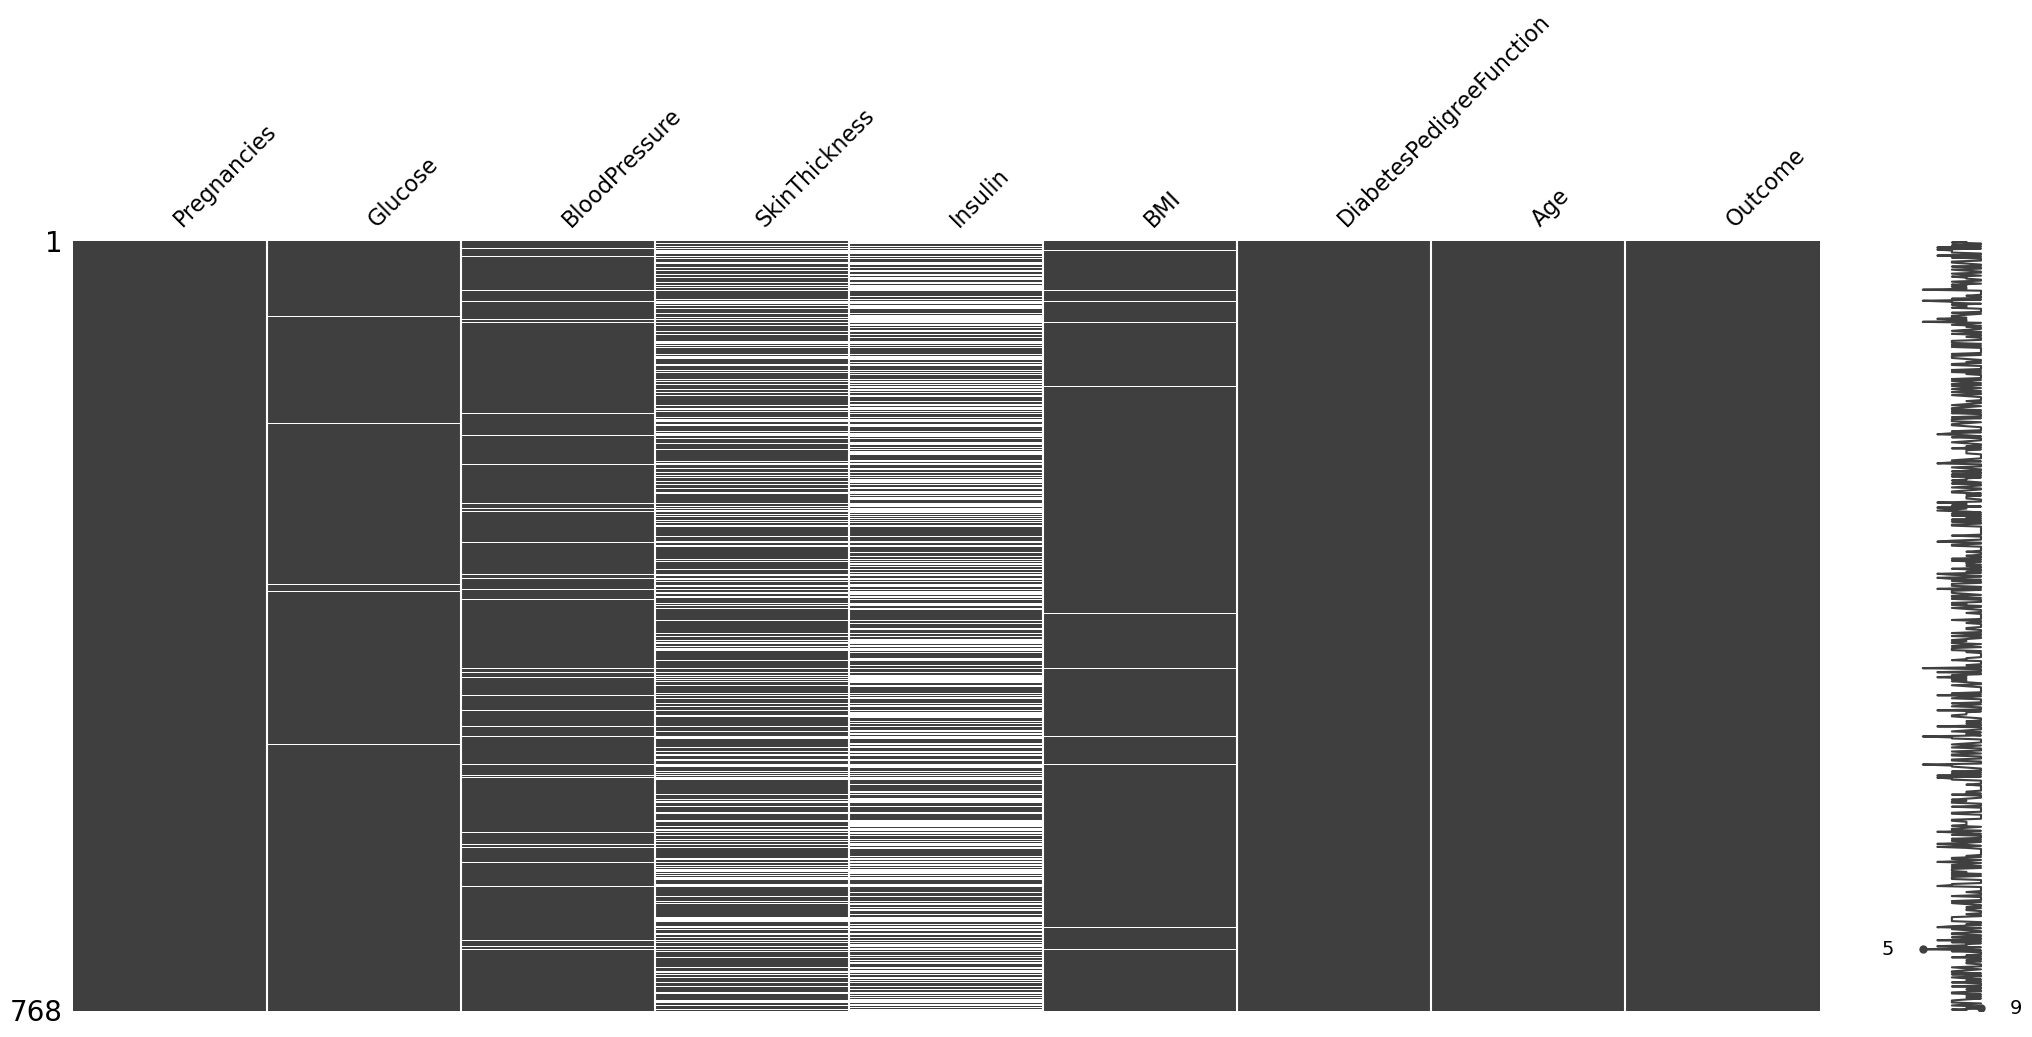

In [15]:
msno.matrix(df)

<Axes: >

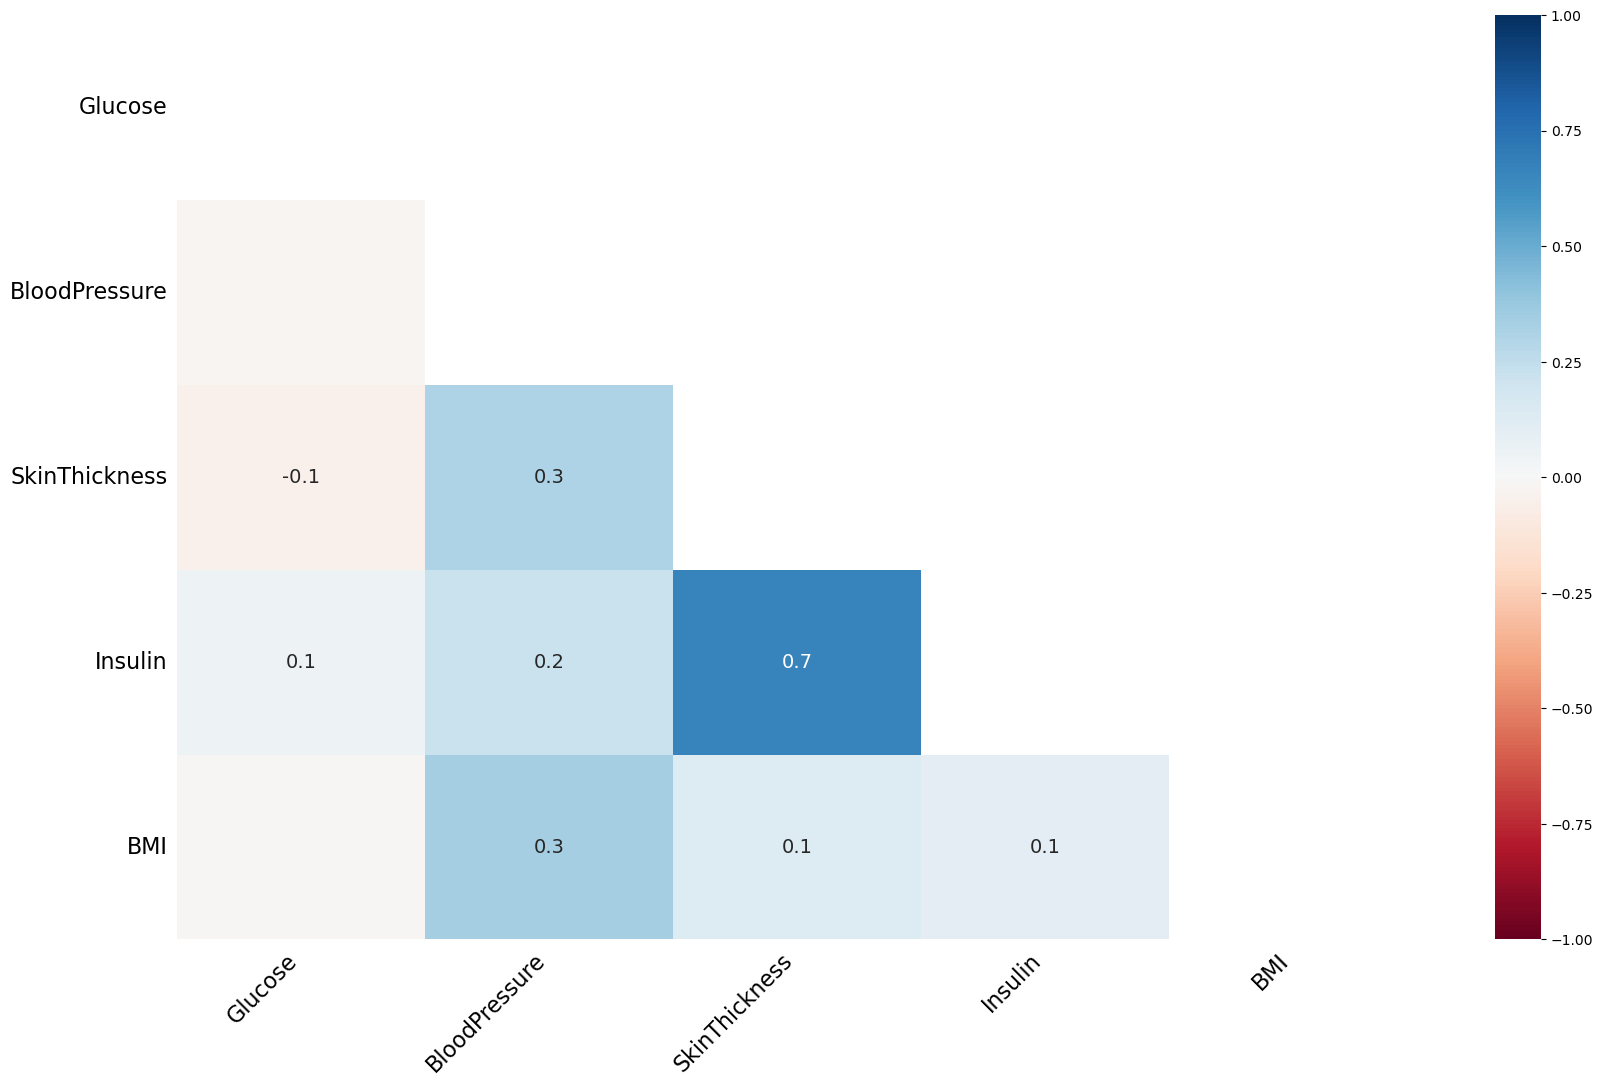

In [16]:
msno.heatmap(df)

<Axes: >

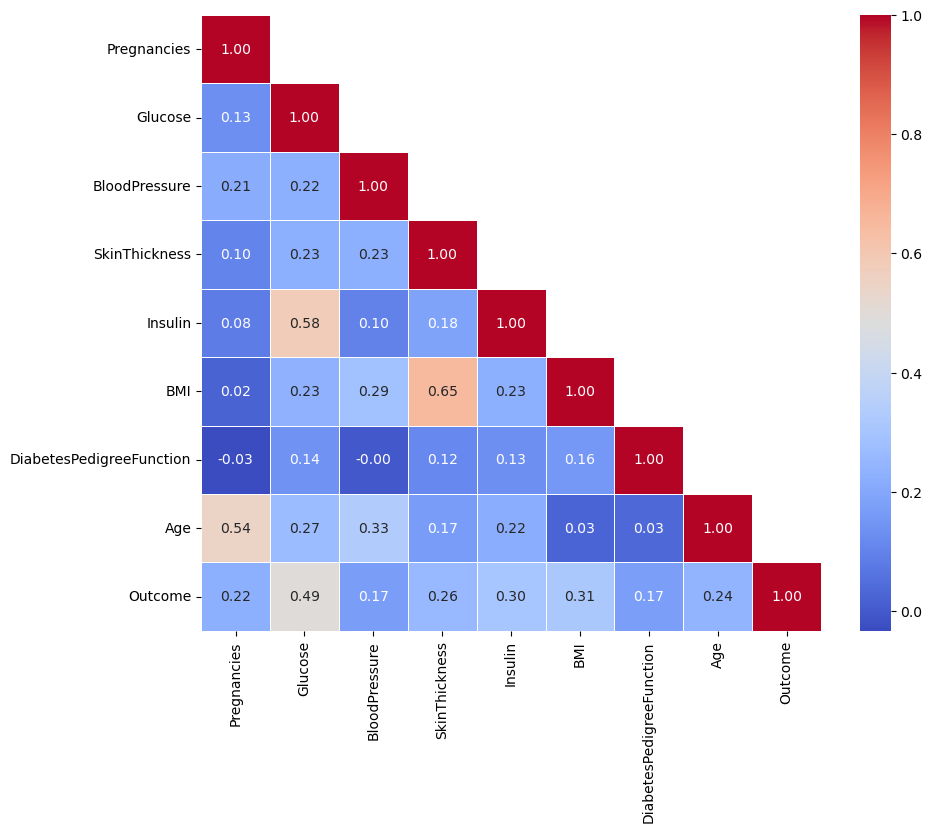

In [17]:
target_column = 'Outcome'

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a custom mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Create a heatmap of the correlation matrix with the mask applied
plt.figure(figsize=(10, 8))  # Adjust the figure size as per your preference
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)

In [18]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [19]:
scaler = MinMaxScaler()

In [20]:
dff = df.copy()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
dff.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.353,0.671,0.490,0.315,NaN,0.315,0.234,0.483,1.000
1,0.059,0.265,0.429,0.247,NaN,0.172,0.117,0.167,0.000
2,0.471,0.897,0.408,NaN,NaN,0.104,0.254,0.183,1.000
3,0.059,0.290,0.429,0.180,0.096,0.202,0.038,0.000,0.000
4,0.000,0.600,0.163,0.315,0.185,0.509,0.944,0.200,1.000


In [21]:
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
dff.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.353,0.671,0.490,0.315,0.385,0.315,0.234,0.483,1.000
1,0.059,0.265,0.429,0.247,0.051,0.172,0.117,0.167,0.000
2,0.471,0.897,0.408,0.283,0.269,0.104,0.254,0.183,1.000
3,0.059,0.290,0.429,0.180,0.096,0.202,0.038,0.000,0.000
4,0.000,0.600,0.163,0.315,0.185,0.509,0.944,0.200,1.000


In [22]:
y = dff["Outcome"]
X = dff.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7792207792207793

In [23]:
confusion_matrix(y_test, y_pred)

array([[130,  20],
       [ 31,  50]], dtype=int64)